In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import io 
from numpy import array
from numpy import hstack
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
#from tsmoothie.utils_func import sim_randomwalk
#from tsmoothie.smoother import *
import seaborn as sns
#import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import optuna
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import optuna
from optuna.integration import KerasPruningCallback
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import os
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras import initializers

In [ ]:
# pip install optuna 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Mildred Lake_Corrected.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True)
# df1 =pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Mildred Lake_Corrected_outlier.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True)
df1 =pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake_all_outlier.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True)

In [ ]:
# df = pd.concat([df1,df2])
# df.index

In [ ]:
df1.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Humidity Inst. (%)',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
def wind (df, radius):
  dff = df.copy()
  a = 'sin'
  b =  'cos'
  dff[a]=np.sin(dff[radius]*np.pi/180)
  dff[b]=np.cos(dff[radius]*np.pi/180)
  #dff[a] = dff[a] * dff[speed]
  #dff[b] = dff[b] * dff[speed]
  # dff.drop(columns=[radius],inplace = True)
  return dff


def lag_maker(df,column, num):
    for i in  range(num):
        df[column+ '-lag' + str(i+1)] = df[column].shift(i+1)
        df[column+ '-lag' + str(i+1)] = df[column+ '-lag' + str(i+1)]

def lag(df_reg, num):
    for i in c:
        lag_maker(df_reg,i,num)
        
    df_reg = df_reg.iloc[num:]
    return df_reg        




# df2 = lag(df1,1)
df1_w = wind(df1,'Wind Direction')

In [ ]:
df1_w.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Humidity Inst. (%)',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score', 'sin', 'cos'],
      dtype='object')

In [ ]:
aa = 'THC (ppm)'

In [ ]:
df1_w= df1_w[[aa, 
          'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Humidity Inst. (%)',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score' ]]


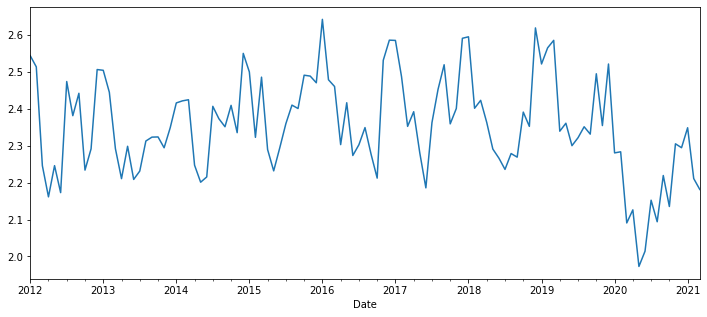

In [ ]:
df1_w[aa].resample('M').mean().plot(figsize = (12,5))

In [ ]:
df1_w.columns

Index(['THC (ppm)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
avg = df1_w['score'].mean()
std = df1_w['score'].std()
len(df1_w[df1_w['score']<avg + 2*std])/len(df1_w)

0.9697012641006746

In [ ]:
def objectivee(trial):    
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00001, random_state = 42)
        param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]), #",,""gblinear" , "dart"
        "lambda": trial.suggest_loguniform("lambda", 0.01, 1000.0),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 1000.0),
        "score" : trial.suggest_float( 'score', avg + 1.5*std, avg + 7 * std )
        }

        # if param["booster"] == "gbtree" :
        #     param["n_estimators"] =  trial.suggest_int("n_estimators" , 1, 10000)

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
            param["eta"] = trial.suggest_loguniform("eta", 0.1, 1000.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 0.1, 1000.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-3, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)

        df_xg =  df1_w[df1_w['score'] < param["score"]].copy()
        df_xg.drop(columns = ['score'], inplace = True)
        Y =  df_xg[aa]
        Y = np.array(Y).reshape(-1,1)
        X = np.array( df_xg[ df_xg.columns[1:]])
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

        K = 5
        kf = KFold(n_splits=K)
        acc = 0 
        for train_index, test_index in kf.split( X_train):   
                X_tr, X_tes =  X_train[train_index],  X_train[test_index]
                y_tr, y_tes =  y_train[train_index],  y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
    
                dtrain = xgb.DMatrix(X_tra, label=y_tra)
                dval = xgb.DMatrix(X_val, label=y_val)
                dtest = xgb.DMatrix(X_tes, label=y_tes)
                
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
                bst = xgb.train(param, dtrain, evals=[(dval, "validation")],  early_stopping_rounds=30,
                                callbacks=[pruning_callback],
                               # verbose_eval = False
                               )
                preds = bst.predict(dtest)
                accuracy = mean_squared_error(y_tes, preds)
                acc = acc + accuracy/K
                
        print(acc)
        return acc    

In [ ]:
study2 = optuna.create_study()
study2.optimize(objectivee, n_trials=5000)
print(study2.best_trial)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/XGB_Mildredlake_OT_THC_HP_hourly.csv')

[I 2021-05-19 14:36:52,507] A new study created in memory with name: no-name-b41d4e6b-47ff-46c9-9c31-2d6bc0c3247f


[0]	validation-rmse:28.0376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:422.65
[2]	validation-rmse:6373.73
[3]	validation-rmse:96117.9
[4]	validation-rmse:1.44949e+06
[5]	validation-rmse:2.18588e+07
[6]	validation-rmse:3.29638e+08
[7]	validation-rmse:4.97106e+09
[8]	validation-rmse:7.49653e+10
[9]	validation-rmse:1.1305e+12
[0]	validation-rmse:27.8369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:419.62
[2]	validation-rmse:6328.03
[3]	validation-rmse:95428.7
[4]	validation-rmse:1.4391e+06
[5]	validation-rmse:2.17021e+07
[6]	validation-rmse:3.27275e+08
[7]	validation-rmse:4.93541e+09
[8]	validation-rmse:7.44277e+10
[9]	validation-rmse:1.1224e+12
[0]	validation-rmse:27.7295
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:418.047
[2]	validation-rmse:6304.28
[3]	validation-rmse:95070.6
[4]	validation-rmse:1.4337e+06
[5]	validation-rmse:2.16206e+07
[6]	validation-rmse:3.26047e+08
[

[I 2021-05-19 14:36:53,537] Trial 0 finished with value: 1.2730896014234177e+24 and parameters: {'booster': 'gbtree', 'lambda': 0.02073082795375375, 'alpha': 37.34377145119307, 'score': 16.96522025799537, 'max_depth': 2, 'eta': 16.08036556081407, 'gamma': 0.01894300890107089, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 1.2730896014234177e+24.


[0]	validation-rmse:1.78756
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.66147
[2]	validation-rmse:1.54565
[3]	validation-rmse:1.43935
[4]	validation-rmse:1.34186
[5]	validation-rmse:1.25258
[6]	validation-rmse:1.17092
[7]	validation-rmse:1.09616
[8]	validation-rmse:1.02811
[9]	validation-rmse:0.966016
[0]	validation-rmse:1.77931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.6544
[2]	validation-rmse:1.5395
[3]	validation-rmse:1.43426
[4]	validation-rmse:1.33771
[5]	validation-rmse:1.24938
[6]	validation-rmse:1.16848
[7]	validation-rmse:1.09475
[8]	validation-rmse:1.0274
[9]	validation-rmse:0.966012
[0]	validation-rmse:1.7639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.63867
[2]	validation-rmse:1.52347
[3]	validation-rmse:1.4178
[4]	validation-rmse:1.32072
[5]	validation-rmse:1.23185
[6]	validation-rmse:1.1504
[7]	validation-rmse:1.07595
[8]	validation-rmse:1.00792
[9]

[I 2021-05-19 14:36:54,204] Trial 1 finished with value: 0.8857722990061687 and parameters: {'booster': 'gbtree', 'lambda': 2.4437625042849525, 'alpha': 0.4020658528853206, 'score': 24.551355198479747, 'max_depth': 2, 'eta': 0.07605964103254954, 'gamma': 0.013858854965223481, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8857722990061687.


0.8857722990061687
[0]	validation-rmse:41.1599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:910.219
[2]	validation-rmse:20132.6
[3]	validation-rmse:445300
[4]	validation-rmse:9.84932e+06
[5]	validation-rmse:2.17851e+08
[6]	validation-rmse:4.81852e+09
[7]	validation-rmse:1.06578e+11
[8]	validation-rmse:2.35733e+12
[9]	validation-rmse:5.21404e+13
[0]	validation-rmse:40.8431
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:903.266
[2]	validation-rmse:19978.7
[3]	validation-rmse:441897
[4]	validation-rmse:9.77407e+06
[5]	validation-rmse:2.16187e+08
[6]	validation-rmse:4.78171e+09
[7]	validation-rmse:1.05764e+11
[8]	validation-rmse:2.33932e+12
[9]	validation-rmse:5.17421e+13
[0]	validation-rmse:40.6504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:899.233
[2]	validation-rmse:19889.8
[3]	validation-rmse:439939
[4]	validation-rmse:9.73096e+06
[5]	validation-rmse:2.15238e+08
[6]	validat

[I 2021-05-19 14:36:55,006] Trial 2 finished with value: 2.6971784451162257e+27 and parameters: {'booster': 'gbtree', 'lambda': 0.6371519528281083, 'alpha': 28.219253091197967, 'score': 26.97193009463727, 'max_depth': 7, 'eta': 23.119953298257393, 'gamma': 31.028727648495607, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.8857722990061687.


[0]	validation-rmse:5.51082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:16.2201
[2]	validation-rmse:47.8139
[3]	validation-rmse:141.06
[4]	validation-rmse:416.133
[5]	validation-rmse:1227.64
[6]	validation-rmse:3621.97
[7]	validation-rmse:10685
[8]	validation-rmse:31522.5
[9]	validation-rmse:93000.4
[0]	validation-rmse:5.48274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:16.1193
[2]	validation-rmse:47.535
[3]	validation-rmse:140.209
[4]	validation-rmse:413.605
[5]	validation-rmse:1220.1
[6]	validation-rmse:3599.24
[7]	validation-rmse:10617.6
[8]	validation-rmse:31321.7
[9]	validation-rmse:92398.3
[0]	validation-rmse:5.46543
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:16.0805
[2]	validation-rmse:47.411
[3]	validation-rmse:139.837
[4]	validation-rmse:412.392
[5]	validation-rmse:1216.3
[6]	validation-rmse:3587.66
[7]	validation-rmse:10583.9
[8]	validation-rmse:31222.4
[9]	va

[I 2021-05-19 14:36:56,457] Trial 3 finished with value: 8917240978.242638 and parameters: {'booster': 'gbtree', 'lambda': 1.275667304573564, 'alpha': 1.7248040587197755, 'score': 28.92642798614829, 'max_depth': 10, 'eta': 3.9543603553048623, 'gamma': 0.9529610242706318, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.8857722990061687.


8917240978.242638
[0]	validation-rmse:0.448297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.401818
[2]	validation-rmse:0.391479
[3]	validation-rmse:0.385069
[4]	validation-rmse:0.381526
[5]	validation-rmse:0.378308
[6]	validation-rmse:0.376837
[7]	validation-rmse:0.375109
[8]	validation-rmse:0.372598
[9]	validation-rmse:0.370129
[0]	validation-rmse:0.460138
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.429258
[2]	validation-rmse:0.416672
[3]	validation-rmse:0.40611
[4]	validation-rmse:0.403036
[5]	validation-rmse:0.400786
[6]	validation-rmse:0.398313
[7]	validation-rmse:0.396147
[8]	validation-rmse:0.393211
[9]	validation-rmse:0.39122
[0]	validation-rmse:0.456249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.414051
[2]	validation-rmse:0.401959
[3]	validation-rmse:0.392471
[4]	validation-rmse:0.388885
[5]	validation-rmse:0.384682
[6]	validation-rmse:0.382354
[7]	validati

[I 2021-05-19 14:36:57,886] Trial 4 finished with value: 0.16535893263285253 and parameters: {'booster': 'gbtree', 'lambda': 75.84578018851322, 'alpha': 18.80685763192907, 'score': 20.450996651365063, 'max_depth': 7, 'eta': 1.0304671699504744, 'gamma': 0.05903851917758863, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.16535893263285253.


[0]	validation-rmse:1.0703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.663254
[2]	validation-rmse:0.48718
[3]	validation-rmse:0.419181
[4]	validation-rmse:0.393813
[5]	validation-rmse:0.38366
[6]	validation-rmse:0.376534
[7]	validation-rmse:0.371759
[8]	validation-rmse:0.369047
[9]	validation-rmse:0.365958
[0]	validation-rmse:1.07304
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.673678
[2]	validation-rmse:0.504095
[3]	validation-rmse:0.438943
[4]	validation-rmse:0.415478
[5]	validation-rmse:0.404549
[6]	validation-rmse:0.395447
[7]	validation-rmse:0.39144
[8]	validation-rmse:0.388986
[9]	validation-rmse:0.385134
[0]	validation-rmse:1.06065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.659493
[2]	validation-rmse:0.48798
[3]	validation-rmse:0.420046
[4]	validation-rmse:0.396213
[5]	validation-rmse:0.383696
[6]	validation-rmse:0.377918
[7]	validation-rmse:0.374274
[8]	val

[I 2021-05-19 14:36:59,323] Trial 5 finished with value: 0.17187754649323 and parameters: {'booster': 'gbtree', 'lambda': 3.21094483906486, 'alpha': 12.493714518584477, 'score': 18.714172585583984, 'max_depth': 7, 'eta': 0.47408029551034075, 'gamma': 0.03449128402253684, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.16535893263285253.


0.17187754649323


[I 2021-05-19 14:36:59,387] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:1.57347
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.30279
[2]	validation-rmse:1.08552
[3]	validation-rmse:0.912307
[4]	validation-rmse:0.775717
[5]	validation-rmse:0.669221
[6]	validation-rmse:0.587774
[7]	validation-rmse:0.525485
[8]	validation-rmse:0.479141
[9]	validation-rmse:0.445349
[0]	validation-rmse:1.57044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.30326
[2]	validation-rmse:1.08921
[3]	validation-rmse:0.918707
[4]	validation-rmse:0.784584
[5]	validation-rmse:0.677835
[6]	validation-rmse:0.597311
[7]	validation-rmse:0.536355
[8]	validation-rmse:0.489474
[9]	validation-rmse:0.455219
[0]	validation-rmse:1.57203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.30581
[2]	validation-rmse:1.09242
[3]	validation-rmse:0.922595
[4]	validation-rmse:0.789406
[5]	validation-rmse:0.686247
[6]	validation-rmse:0.607182
[7]	validation-rmse:0.54769
[8]	valid

KeyboardInterrupt: ignored

In [ ]:
study2.best_params

In [ ]:
study2.best_trials

In [ ]:
best_params ={'alpha': 1.106882270316649,
 'booster': 'gbtree',
 'eta': 0.7538019289379739,
 'gamma': 0.4250365483381551,
 'grow_policy': 'depthwise',
 'lambda': 4.72418554669857,
 'max_depth': 5,
 'score': 17.74305750194141} #number=114, values=[0.1588373125741904]


score = best_params ['score']
booster = best_params['booster']
lambdaa =best_params['lambda']
alpha = best_params['alpha']
# n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']

eta = best_params['eta']
gamma=best_params['gamma']
grow_policy= best_params['grow_policy']
#sample_type=study.best_params['sample_type']
#normalize_type= study.best_params['normalize_type']
#rate_drop=study.best_params['rate_drop']
#skip_drop=study.best_params['skip_drop']
        
df1_w_c2=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_c2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_THC_Dataset.csv')

df1_w_c = df1_w_c2.copy()  
# df1_w_c = df1_w.copy() 

df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


98.01740264157361


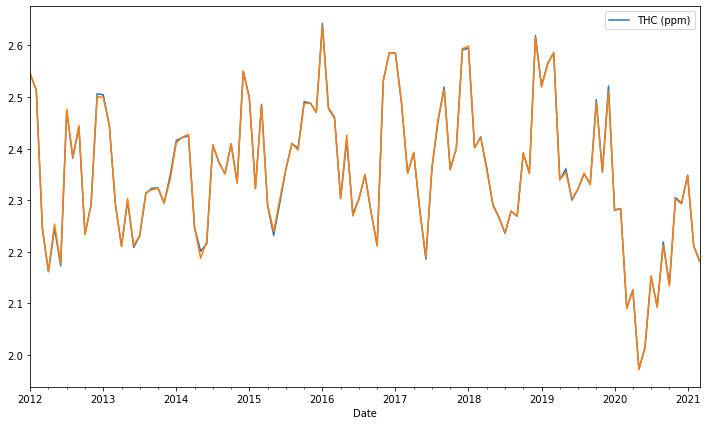

In [ ]:
A = 'M'
df1_w[aa].resample(A).mean().plot(legend = True,figsize = (12,7))
df1_w_c[aa].resample(A).mean().plot()


In [ ]:
print(len(df1_w_c)*100/len(df1_w))

98.01740264157361


[0]	validation_0-rmse:1.72969
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.56773
[2]	validation_0-rmse:1.42302
[3]	validation_0-rmse:1.29374
[4]	validation_0-rmse:1.17835
[5]	validation_0-rmse:1.07597
[6]	validation_0-rmse:0.984928
[7]	validation_0-rmse:0.9043
[8]	validation_0-rmse:0.833083
[9]	validation_0-rmse:0.770488
[10]	validation_0-rmse:0.715776
[11]	validation_0-rmse:0.66797
[12]	validation_0-rmse:0.626671
[13]	validation_0-rmse:0.59039
[14]	validation_0-rmse:0.559506
[15]	validation_0-rmse:0.532601
[16]	validation_0-rmse:0.509912
[17]	validation_0-rmse:0.490097
[18]	validation_0-rmse:0.473338
[19]	validation_0-rmse:0.459234
[20]	validation_0-rmse:0.447105
[21]	validation_0-rmse:0.43728
[22]	validation_0-rmse:0.428828
[23]	validation_0-rmse:0.421838
[24]	validation_0-rmse:0.415917
[25]	validation_0-rmse:0.410767
[26]	validation_0-rmse:0.406448
[27]	validation_0-rmse:0.403079
[28]	validation_0-rmse:0.400273
[29]	validation_0-rmse:0.397

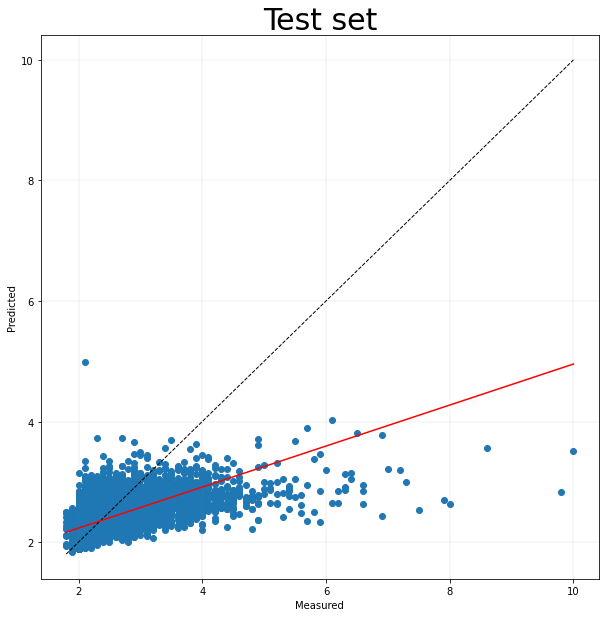

[0.340191   1.55165231]
RMSE
[0.35425109]
R2
0.3768468990341942


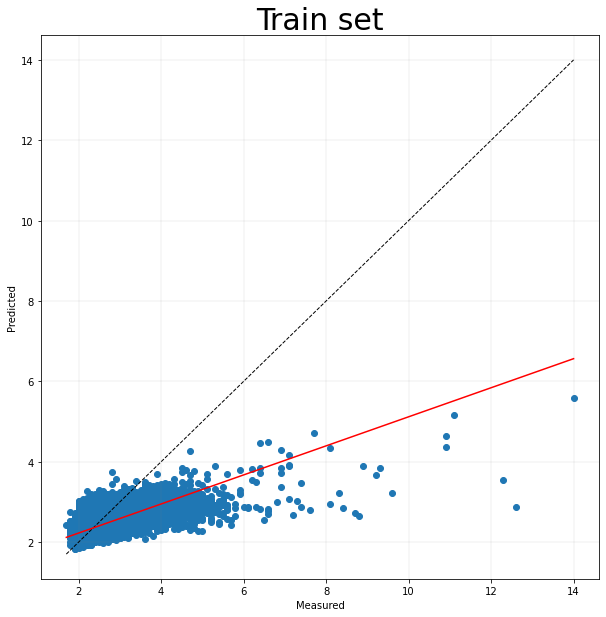

[0.36158751 1.50139968]
RMSE
[0.34532839]
R2
0.4272559584234191


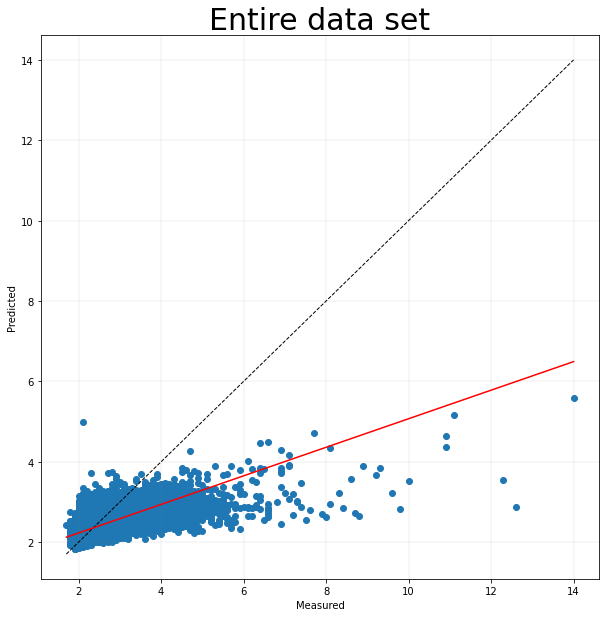

[0.35531732 1.51614267]
RMSE
[0.34802929]
R2
0.41249202064835455


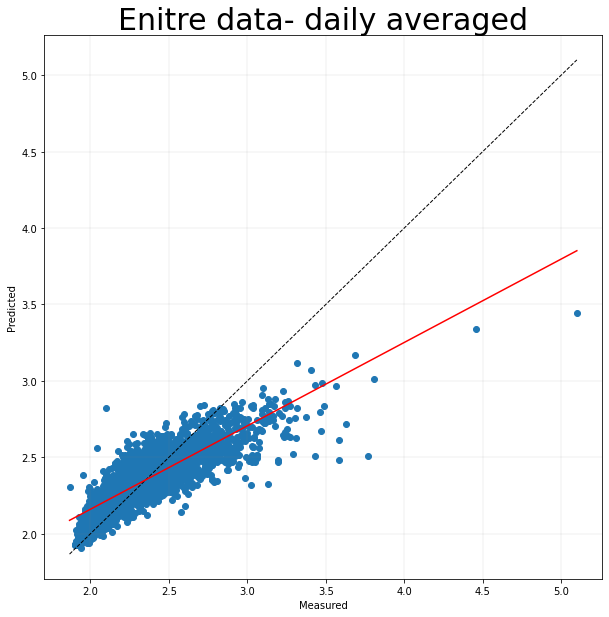

[0.54554888 1.06923368]
RMSE
[0.15660407]
R2
0.657902434666352


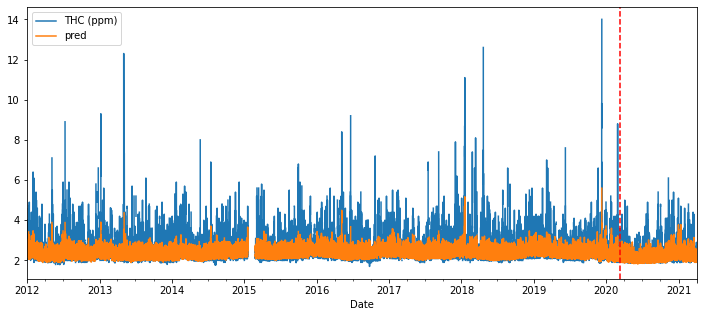

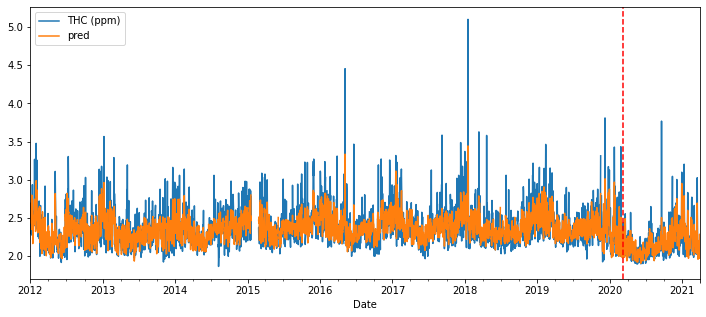

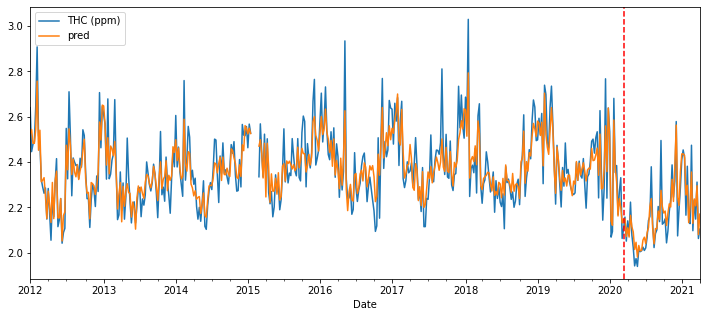

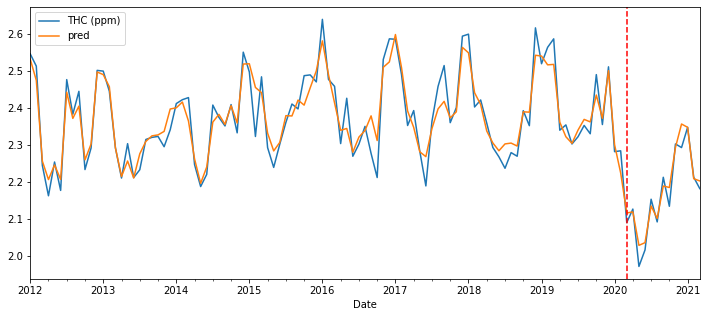

In [ ]:
model= xgb.XGBRegressor(booster = booster, reg_lambda=lambdaa, alpha=alpha,  
                          max_depth = max_depth, eta = eta, gamma = gamma,
                          grow_policy = grow_policy,
                          # n_estimators=n_estimators,
                          objective ='reg:squarederror', 
                          #normalize_type=normalize_type,sample_type=sample_type,rate_drop=rate_drop,skip_drop=skip_drop,
                          random_state=42)

eval_set = [(X_val, y_val)]
model.fit(X_traine, y_traine, early_stopping_rounds=20, eval_metric="rmse", eval_set=eval_set)


preds = model.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))


# df3= df3.copy()
df4 = df1_w_c.copy() #hereee
df4['pred'] = model.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean().copy()
df10.dropna(inplace= True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(df10[aa]).reshape(-1,1)
y_pred = np.array(df10['pred']).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Enitre data- daily averaged',fontsize=30)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()
print(par)
print('RMSE')
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))



df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4.columns

Index(['THC (ppm)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = ['T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_THC_OT_XG_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_THC_OT_XG_Test.csv')


[0.34532839]
0.4272559584234191
[0.35425109]
0.3768468990341942


In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
223
2.3685262203216553
2021-01-12 13:00:00
223
2.3660125732421875
2021-01-12 14:00:00
222
2.365679979324341
2021-01-12 15:00:00
228
2.3558552265167236
2021-01-12 16:00:00
233
2.348378896713257
2021-01-12 17:00:00
241
2.3192336559295654
2021-01-12 18:00:00
242
2.3213658332824707
2021-01-12 19:00:00
245
2.3013381958007812
2021-01-12 20:00:00
245
2.3084118366241455
2021-01-12 21:00:00
246
2.314628839492798
2021-01-12 22:00:00
245
2.305110216140747
2021-01-12 23:00:00
243
2.3126282691955566
2021-01-13 02:00:00
100
2.282745361328125
2021-01-13 03:00:00
198
2.2794103622436523
2021-01-13 04:00:00
205
2.3001441955566406
2021-01-13 05:00:00
204
2.286886215209961
2021-01-13 06:00:00
234
2.27652645111084
2021-01-13 07:00:00
253
2.272048234939575
2021-01-13 08:00:00
247
2.2977426052093506
2021-01-13 09:00:00
249
2.2910943031311035
2021-01-13 10:00:00
235
2.2902514934539795
2021-01-13 11:00:00
229
2.3114588260650635
2021-01-13 12:00:00
232
2.359923

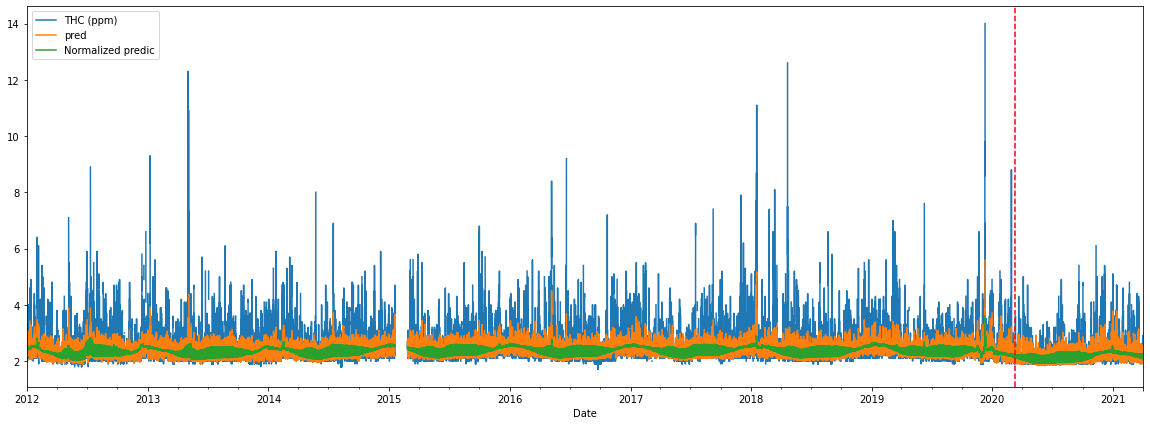

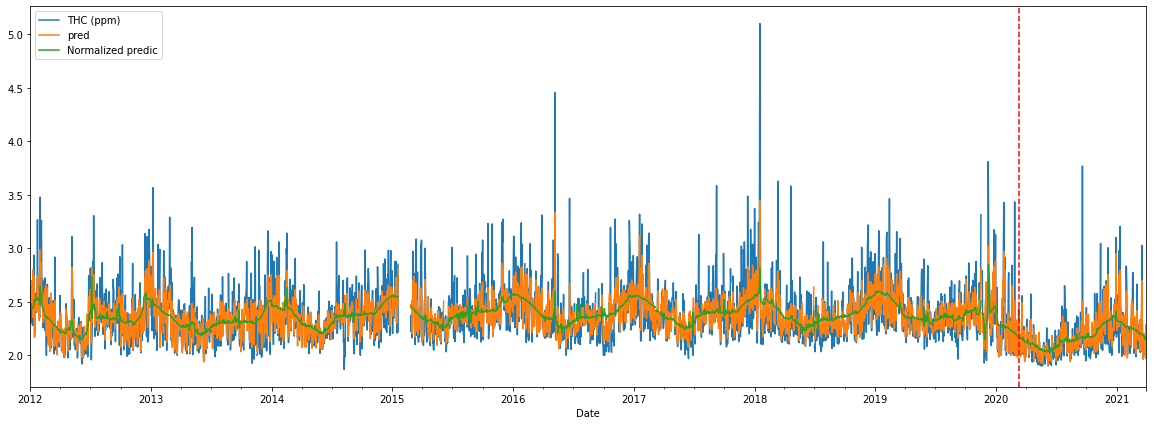

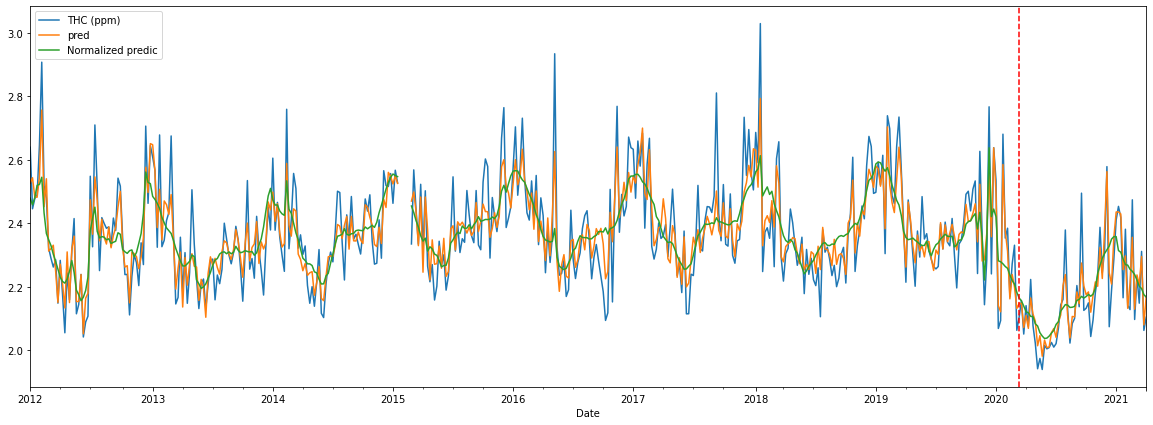

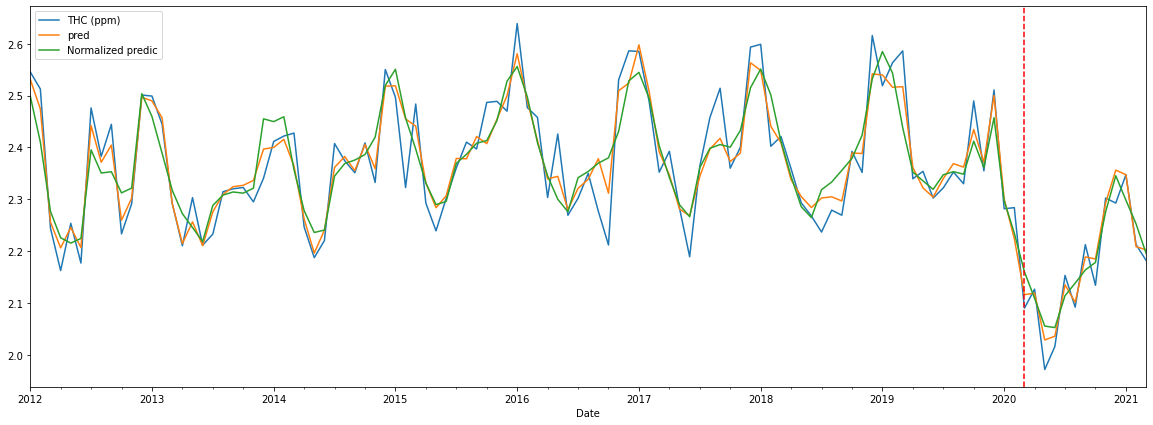

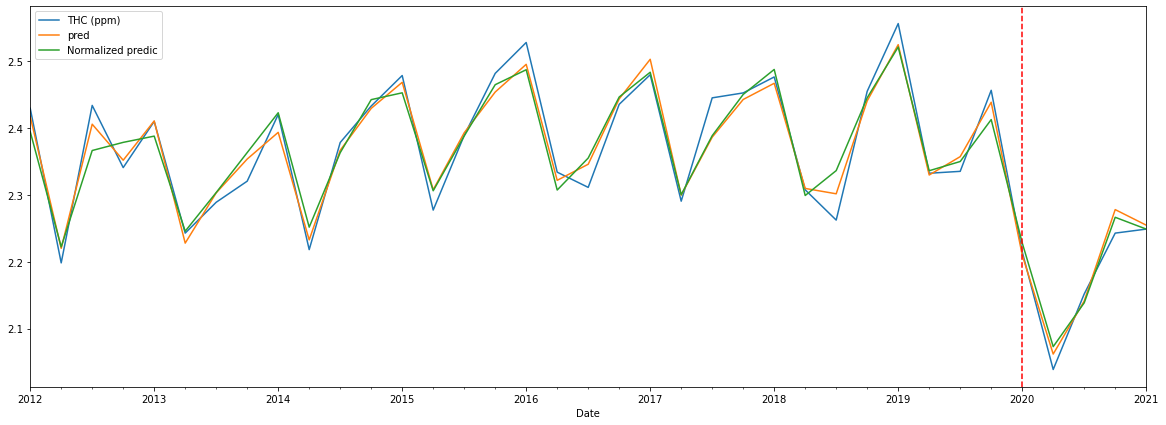

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_THC_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_THC_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_THC_Monthly_normalized_pred.csv')

for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
################################################################################

In [ ]:
maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

avg = df1_w['score'].mean()
std = df1_w['score'].std()

print(avg,std)

5.412817221383143 4.741954031234103


In [ ]:
class Objective(object):
    def __init__(self,df1_w, max_epochs, learn_rate_epochs,
                  ):
       
        # self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.11, random_state=42)
        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.df1_w = df1_w.copy()
        self.n_features = len(self.df1_w.columns)-1

    def __call__(self, trial):        
        dict_params = {
                        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std ),
                        'layers': trial.suggest_int('layers', 2,3),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                        'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,5000,500)),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 20,40),
                        'delta': trial.suggest_float(  'delta',1, 100),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                       'drop_out1': trial.suggest_float('drop_out1',0.05, 0.3)}  
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        dict_params['num_dense_nodes2'] = trial.suggest_int('num_dense_nodes2', 20,40)
        dict_params['drop_out2'] =trial.suggest_float('drop_out2',0.05, 0.5)

        if dict_params['layers'] == 3:
            dict_params['num_dense_nodes3'] = trial.suggest_int('num_dense_nodes3', 5,40)
            dict_params['drop_out3'] = trial.suggest_float('drop_out3',0.05, 0.5)


        self.df_nn =  self.df1_w[self.df1_w['score'] <  dict_params["score"]].copy()
        self.df_nn.drop(columns = ['score'], inplace = True)
        self.Y =   self.df_nn[aa]
        self.Y = np.array(self.Y).reshape(-1,1)
        self.X = np.array( self.df_nn[  self.df_nn.columns[1:]])
        # self.X_train =self.X
        # self.y_train =self.Y
        self.X_train,  self.X_test,  self.y_train, self.y_test = train_test_split( self.X,   self.Y, test_size=0.3, random_state = 42)
          
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(dict_params['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha= dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out1']))
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        model.add(Dense(dict_params['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out2']))
        if dict_params['layers'] == 3 :
            model.add(Dense(dict_params['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
            model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
            model.add(Dropout(dict_params['drop_out3']))
        model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params[ 'learning_rate'])
        model.compile(loss=
                      # 'mse',
                      tf.keras.losses.Huber( delta=dict_params[ 'delta']),
                      # 'mse'
                          optimizer=opt)
        fn = "gdrive/My Drive/Colab Notebooks/Stations/Mildred_Lake_THC" +str(trial.number) + ".ckpt" 
        fnn = os.path.dirname(fn)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 4
        kf = KFold(n_splits=n_f )
        acc = 0 
        for train_index, test_index in kf.split( self.X_train):   
                X_tr, X_tes =  self.X_train[train_index],  self.X_train[test_index]
                y_tr, y_tes =   self.y_train[train_index],   self.y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
                h = model.fit(x=X_tra, y=y_tra,
                                  validation_data=(X_val, y_val),
                                  batch_size=dict_params['batchsize'],
                                  epochs=self.max_epochs,
                                  shuffle=True, verbose=0,
                                  callbacks=callbacks_list)
                model.load_weights(fn)
                preds = model.predict(X_tes)
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 

        print(acc)
        return acc    

In [ ]:
# objective = Objective(df1_w,maximum_epochs,learning_rate_epochs)
# study = optuna.create_study(direction=optimizer_direction, study_name='MildredLake_THC_NN', storage='sqlite:///MildredLake_THC_NN.db',
#                             load_if_exists=True)
# study.optimize(objective, n_trials=500)
df_results = study.trials_dataframe()
df_results.to_csv('gdrive/My Drive/Colab Notebooks/results/NN_MildredLake_THC_2013_HP_HUBer.csv')
#df_results.to_pickle('Desktop\heel\df_optuna_results.pkl')

In [ ]:
study.best_trials

[FrozenTrial(number=204, values=[0.13269228415631956], datetime_start=datetime.datetime(2021, 5, 19, 21, 47, 45, 658728), datetime_complete=datetime.datetime(2021, 5, 19, 21, 50, 53, 767919), params={'score': 26.330914273510107, 'layers': 3, 'alpha': 0.05091563269176176, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 97.851801753821, 'learning_rate': 0.012793423933344143, 'drop_out1': 0.05146618842015081, 'num_dense_nodes2': 26, 'drop_out2': 0.25919910611555563, 'num_dense_nodes3': 14, 'drop_out3': 0.062484486460312745}, distributions={'score': UniformDistribution(high=29.122587377553657, low=14.89672528385135), 'layers': IntUniformDistribution(high=3, low=2, step=1), 'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=4600.0, low=100.0, q=500.0), 'num_dense_nodes1': IntUniformDistribution(high=40, low=20, step=1), 'delta': UniformDistribution(high=100.0, low=1.0), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'drop_out1': 

In [ ]:
study.best_params

{'alpha': 0.05091563269176176,
 'batchsize': 600.0,
 'delta': 97.851801753821,
 'drop_out1': 0.05146618842015081,
 'drop_out2': 0.25919910611555563,
 'drop_out3': 0.062484486460312745,
 'layers': 3,
 'learning_rate': 0.012793423933344143,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 26,
 'num_dense_nodes3': 14,
 'score': 26.330914273510107}

In [ ]:
# best_params ={'layers': 3, 
#  'alpha': 0.0526980274446888, 
#  'batchsize': 4600.0, 
#  'num_dense_nodes1': 36, 
#  'learning_rate': 0.018484616832439602,
#  'drop_out1': 0.05996259416109538,
#  'num_dense_nodes2': 39, 
#  'drop_out2': 0.1405312487713208, 
#  'num_dense_nodes3': 32, 
#  'drop_out3': 0.0817600247911929} #Best is trial 451 with value: 12.209992355603418. opt1



best_params ={'alpha': 0.05091563269176176,
 'batchsize': 600.0,
 'delta': 97.851801753821,
 'drop_out1': 0.05146618842015081,
 'drop_out2': 0.25919910611555563,
 'drop_out3': 0.062484486460312745,
 'layers': 3,
 'learning_rate': 0.012793423933344143,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 26,
 'num_dense_nodes3': 14,
 'score': 26.330914273510107} #number=204, values=[0.13269228415631956]

In [ ]:
best_params 

{'alpha': 0.05091563269176176,
 'batchsize': 600.0,
 'delta': 97.851801753821,
 'drop_out1': 0.05146618842015081,
 'drop_out2': 0.25919910611555563,
 'drop_out3': 0.062484486460312745,
 'layers': 3,
 'learning_rate': 0.012793423933344143,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 26,
 'num_dense_nodes3': 14,
 'score': 26.330914273510107}

In [ ]:
df1_w_cn=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_cn.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_Mildred_Lake_THC_Dataset.csv')

df1_w_c = df1_w_cn.copy()  
# df1_w_c = df1_w.copy() 
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)



maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds
best_params

99.21206280823083


{'alpha': 0.05091563269176176,
 'batchsize': 600.0,
 'delta': 97.851801753821,
 'drop_out1': 0.05146618842015081,
 'drop_out2': 0.25919910611555563,
 'drop_out3': 0.062484486460312745,
 'layers': 3,
 'learning_rate': 0.012793423933344143,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 26,
 'num_dense_nodes3': 14,
 'score': 26.330914273510107}

In [ ]:
df1_w_c.columns

Index(['THC (ppm)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

Epoch 1/250
62/62 - 1s - loss: 0.5501 - val_loss: 0.4518
Epoch 2/250
62/62 - 0s - loss: 0.1323 - val_loss: 0.1004
Epoch 3/250
62/62 - 0s - loss: 0.1209 - val_loss: 0.0920
Epoch 4/250
62/62 - 0s - loss: 0.1162 - val_loss: 0.0872
Epoch 5/250
62/62 - 0s - loss: 0.1097 - val_loss: 0.0855
Epoch 6/250
62/62 - 0s - loss: 0.1067 - val_loss: 0.0860
Epoch 7/250
62/62 - 0s - loss: 0.1046 - val_loss: 0.0857
Epoch 8/250
62/62 - 0s - loss: 0.1035 - val_loss: 0.0850
Epoch 9/250
62/62 - 0s - loss: 0.1021 - val_loss: 0.0849
Epoch 10/250
62/62 - 0s - loss: 0.1016 - val_loss: 0.0878
Epoch 11/250
62/62 - 0s - loss: 0.1006 - val_loss: 0.0842
Epoch 12/250
62/62 - 0s - loss: 0.0995 - val_loss: 0.0838
Epoch 13/250
62/62 - 0s - loss: 0.0969 - val_loss: 0.0823
Epoch 14/250
62/62 - 0s - loss: 0.0952 - val_loss: 0.0786
Epoch 15/250
62/62 - 0s - loss: 0.0948 - val_loss: 0.0790
Epoch 16/250
62/62 - 0s - loss: 0.0930 - val_loss: 0.0777
Epoch 17/250
62/62 - 0s - loss: 0.0934 - val_loss: 0.0759
Epoch 18/250
62/62 - 0s

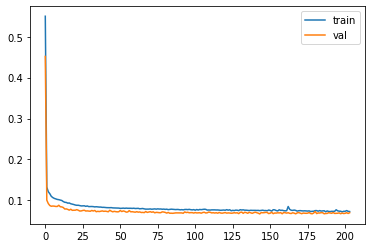

Model: "sequential_272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_272 (Bat (None, 13)                52        
_________________________________________________________________
dense_1078 (Dense)           (None, 40)                560       
_________________________________________________________________
leaky_re_lu_1078 (LeakyReLU) (None, 40)                0         
_________________________________________________________________
dropout_806 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_1079 (Dense)           (None, 26)                1066      
_________________________________________________________________
leaky_re_lu_1079 (LeakyReLU) (None, 26)                0         
_________________________________________________________________
dropout_807 (Dropout)        (None, 26)             

In [ ]:
model_NN = Sequential()
model_NN.add(BatchNormalization())
model_NN.add(Dense(best_params ['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha= best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out1']))
# if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
model_NN.add(Dense(best_params ['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out2']))
if best_params ['layers'] == 3 :
    model_NN.add(Dense(best_params ['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
    model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
    model_NN.add(Dropout(best_params ['drop_out3']))
model_NN.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
# instantiate and compile model
opt = keras.optimizers.Adam(learning_rate=best_params [ 'learning_rate'])
model_NN.compile(loss=
                #  'mse',
              tf.keras.losses.Huber( delta=best_params[ 'delta']),
              # 'mse'
                  optimizer=opt)
fn = "gdrive/My Drive/Colab Notebooks/Stations/Mildred_Lake_THC.ckpt" 
fnn = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model_NN.fit(x=X_traine, y= y_traine,
                  validation_data=(X_val, y_val),
                  batch_size=int(best_params['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
model_NN.summary()

In [ ]:
model_NN.load_weights(fn)
precovid_model = 'gdrive/My Drive/Colab Notebooks/Milkdlake_THC_OUT.h5'
model_NN.save(precovid_model )

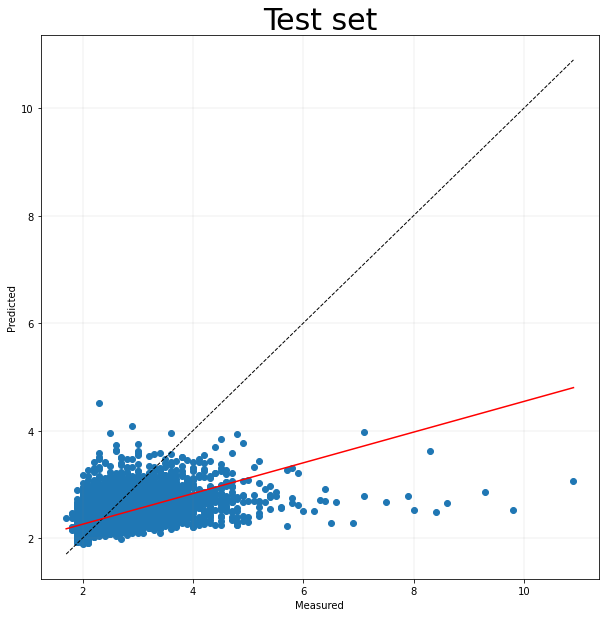

[0.28565276 1.68522099]
RMSE
[0.37189715]
R2
0.30510183485574993


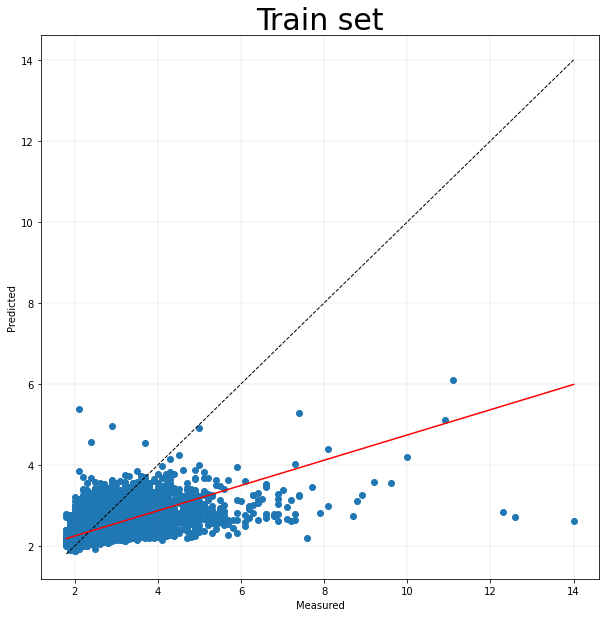

[0.31174446 1.62365245]
RMSE
[0.36830259]
R2
0.3569349430231552


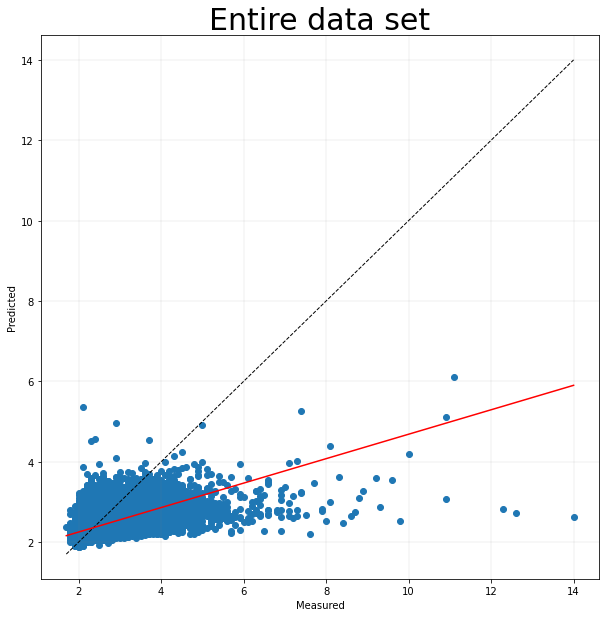

[0.30423085 1.64139549]
RMSE
[0.36938466]
R2
0.3420120295365334


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model_NN.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model_NN.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

Model: "sequential_272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_272 (Bat (None, 13)                52        
_________________________________________________________________
dense_1078 (Dense)           (None, 40)                560       
_________________________________________________________________
leaky_re_lu_1078 (LeakyReLU) (None, 40)                0         
_________________________________________________________________
dropout_806 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_1079 (Dense)           (None, 26)                1066      
_________________________________________________________________
leaky_re_lu_1079 (LeakyReLU) (None, 26)                0         
_________________________________________________________________
dropout_807 (Dropout)        (None, 26)             

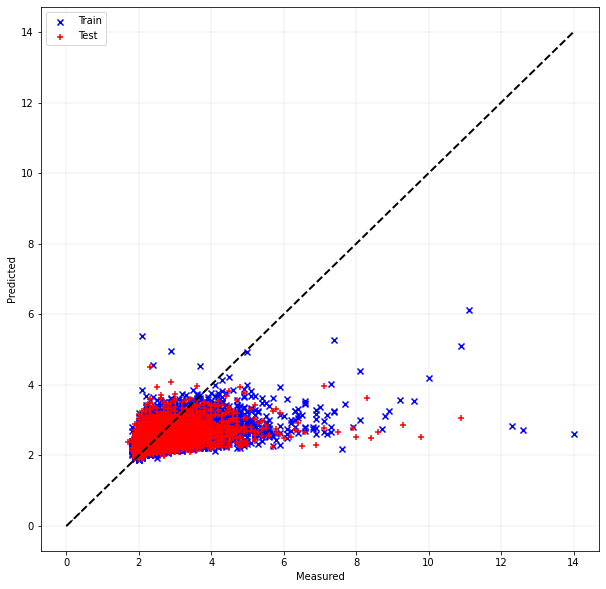

In [ ]:
model_NN = load_model(precovid_model )
model_NN.summary()
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.5], [0,0.5], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [ ]:
# df3= df3.copy()
df4 = df1_w_c.copy()
df4['pred'] = model_NN.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

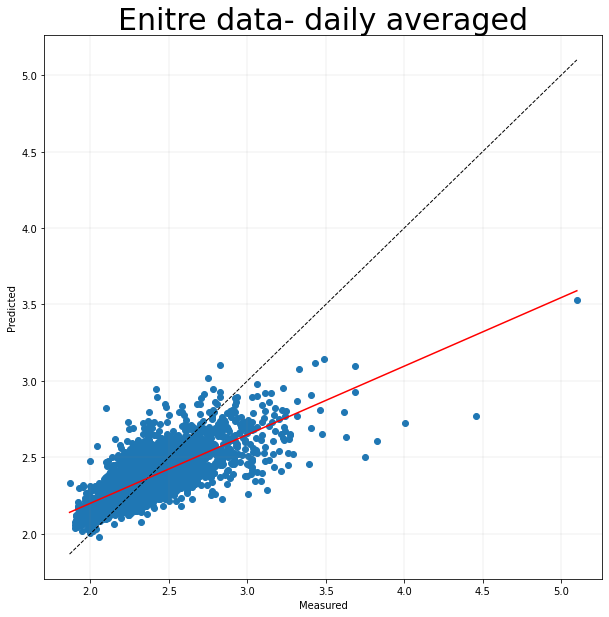

[0.44842715 1.30262036]
RMSE
[0.18071853]
R2
0.5448855614324545


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10[aa]).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


In [ ]:
df4.columns

Index(['THC (ppm)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

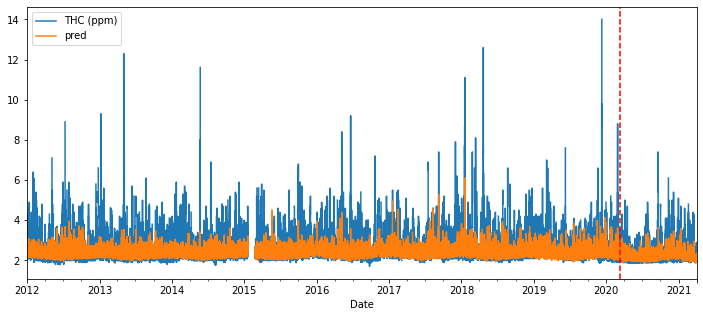

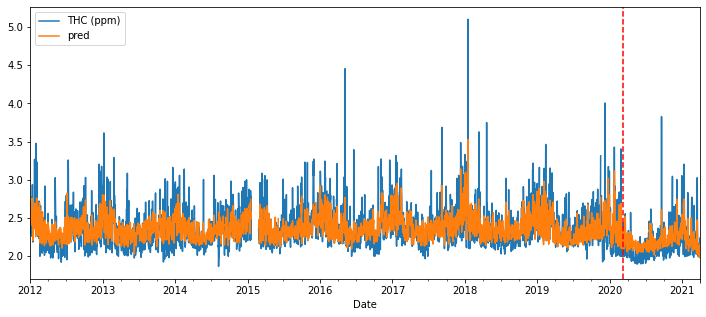

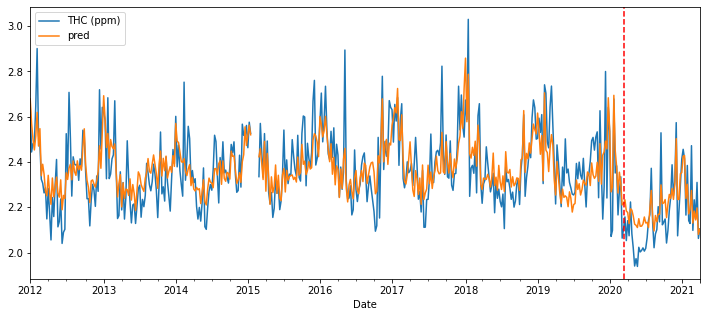

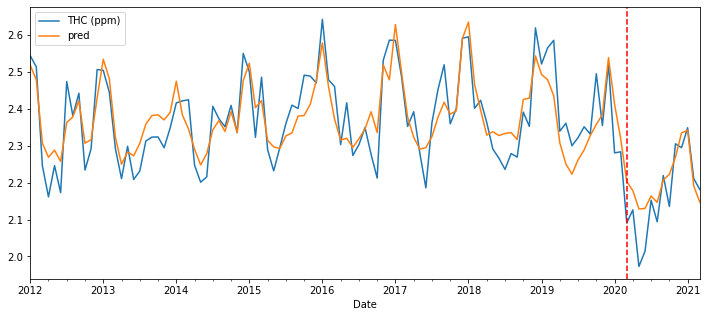

In [ ]:
df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
preds1 = model_NN.predict(X_train) 
y_real1 = y_train.reshape(-1,1)
y_pred1 = preds1.reshape(-1,1)
print(rmse(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))

[0.36830259]
0.3569349430231552


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

[0.37189715]
0.30510183485574993


In [ ]:
df4.columns

Index(['THC (ppm)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model_NN.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model_NN.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = ['T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_NN_THC_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_NN_THC_Test.csv')

[0.36830259]
0.3569349430231552
[0.37189715]
0.30510183485574993


ValueError: ignored

In [ ]:
df4.columns

Index(['THC (ppm)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model_NN.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
257
2.2814717292785645
2021-01-13 08:00:00
252
2.2845966815948486
2021-01-13 09:00:00
251
2.28753399848938
2021-01-13 10:00:00
239
2.285367965698242
2021-01-13 11:00:00
236
2.298693895339966
2021-01-13 12:00:00
236
2.3174266815185547
2021-01-13 13:00:00
236
2.3189761638641357
2021-01-13 14:00:00
235
2.321833848953247
2021-01-13 15:00:00
238
2.3385732173919678
2021-01-13 16:00:00
247
2.3517541885375977
2021-01-13 17:00:00
255
2.328014612197876
2021-01-13 18:00:00
257
2.335371255874634
2021-01-13 19:00:00
257
2.3205933570861816
2021-01-13 20:00:00
257
2.327566385269165
2021-01-13 21:00:00
258
2.3063385486602783
2021-01-13 22:00:00
255
2.3098793029785156
2021-01-13 23:00:00
255
2.322174310684204
2021-01-14 00:00:00
230
2.293923854827881
2021-01-14 03:00:00
205
2.285855531692505
2021-01-14 04:00:00
210
2.287754774093628
2021-01-14 05:00:00
217
2.2797303199768066
2021-01-14 06:00:00
250
2.278184175491333
2021-01-14 07:00:00
266
2.2804150581

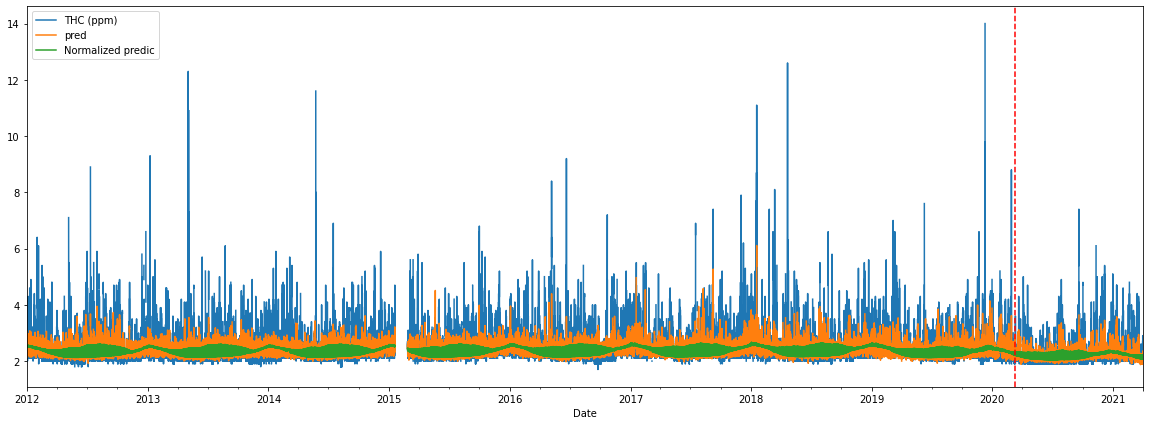

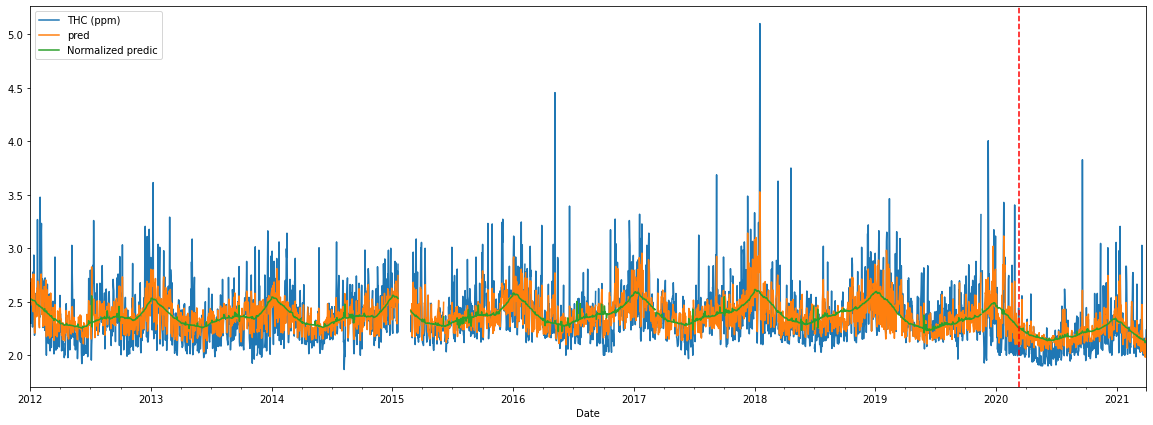

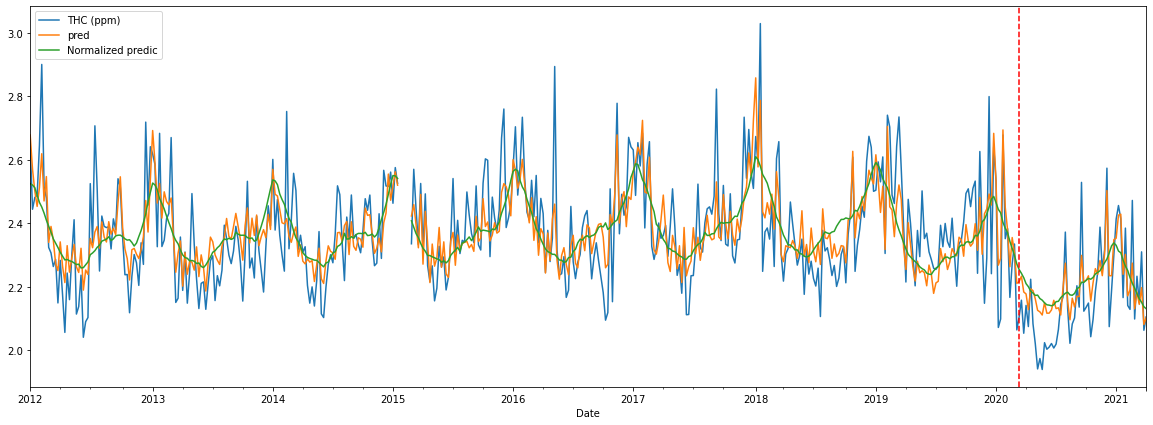

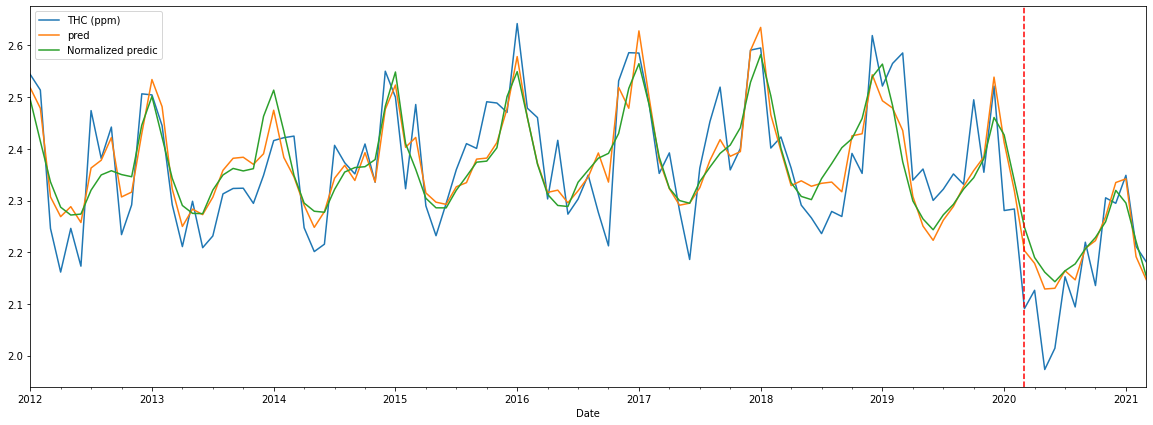

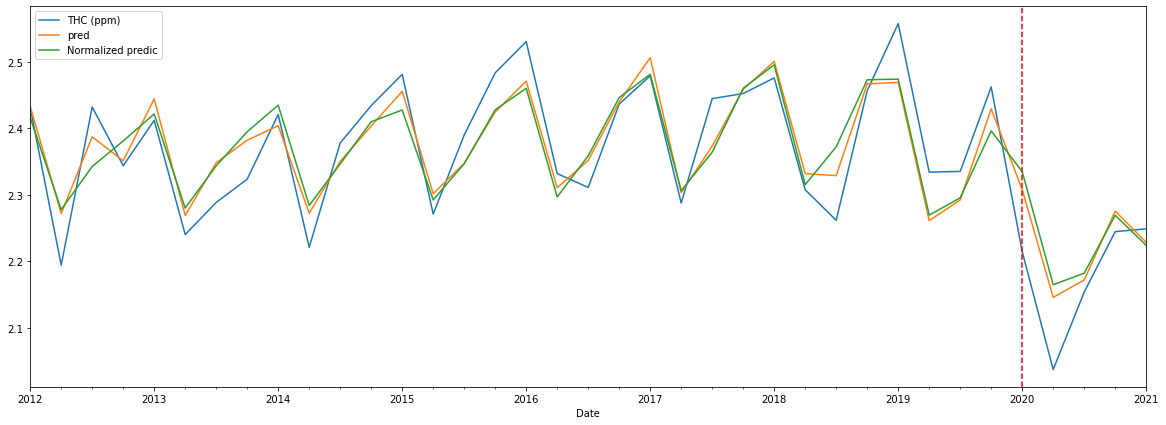

In [ ]:
z = np.array(z).reshape(-1,1)
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_THC_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_THC_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_THC_Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

df4_h[aa].resample('Y').mean().loc['2018':].plot(legend= True)
df4_h['pred'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
df4_h['Normalized predic'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
####